# Programming Assignment

## Residual network

### Instructions

In this notebook, you will use the model subclassing API together with custom layers to create a residual network architecture. You will then train your custom model on the Fashion-MNIST dataset by using a custom training loop and implementing the automatic differentiation tools in Tensorflow to calculate the gradients for backpropagation.

Some code cells are provided you in the notebook. You should avoid editing provided code, and make sure to execute the cells in order to avoid unexpected errors. Some cells begin with the line: 

`#### GRADED CELL ####`

Don't move or edit this first line - this is what the automatic grader looks for to recognise graded cells. These cells require you to write your own code to complete them, and are automatically graded when you submit the notebook. Don't edit the function name or signature provided in these cells, otherwise the automatic grader might not function properly. Inside these graded cells, you can use any functions or classes that are imported below, but make sure you don't use any variables that are outside the scope of the function.

### How to submit

Complete all the tasks you are asked for in the worksheet. When you have finished and are happy with your code, press the **Submit Assignment** button at the top of this notebook.

### Let's get started!

We'll start running some imports, and loading the dataset. Do not edit the existing imports in the following cell. If you would like to make further Tensorflow imports, you should add them here.

In [1]:
#### PACKAGE IMPORTS ####

# Run this cell first to import all required packages. Do not make any imports elsewhere in the notebook

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, BatchNormalization, Conv2D, Dense, Flatten, Add
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# If you would like to make further imports from tensorflow, add them here



#### The Fashion-MNIST dataset

In this assignment, you will use the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). It consists of a training set of 60,000 images of fashion items with corresponding labels, and a test set of 10,000 images. The images have been normalised and centred. The dataset is frequently used in machine learning research, especially as a drop-in replacement for the MNIST dataset. 

- H. Xiao, K. Rasul, and R. Vollgraf. "Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms." arXiv:1708.07747, August 2017.

Your goal is to construct a ResNet model that classifies images of fashion items into one of 10 classes.

#### Load the dataset

For this programming assignment, we will take a smaller sample of the dataset to reduce the training time.

In [2]:
# Load and preprocess the Fashion-MNIST dataset

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images.astype(np.float32)
test_images = test_images.astype(np.float32)

train_images = train_images[:5000] / 255.
train_labels = train_labels[:5000]

test_images = test_images / 255.

train_images = train_images[..., np.newaxis]
test_images = test_images[..., np.newaxis]

In [3]:
# Create Dataset objects for the training and test sets

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(32)

In [4]:
# Get dataset labels

image_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#### Create custom layers for the residual blocks

You should now create a first custom layer for a residual block of your network. Using layer subclassing, build your custom layer according to the following spec:

* The custom layer class should have `__init__`, `build` and `call` methods. The `__init__` method has been completed for you. It calls the base `Layer` class initializer, passing on any keyword arguments
* The `build` method should create the layers. It will take an `input_shape` argument, and should extract the number of filters from this argument. It should create:
    * A BatchNormalization layer: this will be the first layer in the block, so should use its `input shape` keyword argument
    * A Conv2D layer with the same number of filters as the layer input, a 3x3 kernel size, `'SAME'` padding, and no activation function
    * Another BatchNormalization layer
    * Another Conv2D layer, again with the same number of filters as the layer input, a 3x3 kernel size, `'SAME'` padding, and no activation function
* The `call` method should then process the input through the layers:
    * The first BatchNormalization layer: ensure to set the `training` keyword argument
    * A `tf.nn.relu` activation function
    * The first Conv2D layer
    * The second BatchNormalization layer: ensure to set the `training` keyword argument
    * Another `tf.nn.relu` activation function
    * The second Conv2D layer
    * It should then add the layer inputs to the output of the second Conv2D layer. This is the final layer output

In [5]:
#### GRADED CELL ####

# Complete the following class. 
# Make sure to not change the class or method names or arguments.

class ResidualBlock(Layer):

    def __init__(self, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        
    def build(self, input_shape):
        """
        This method should build the layers according to the above specification. Make sure 
        to use the input_shape argument to get the correct number of filters, and to set the
        input_shape of the first layer in the block.
        """
        self.batch_1 = BatchNormalization(input_shape = input_shape)
        self.conv_1 = Conv2D(input_shape[-1], (3,3), padding='same')
        self.batch_2 = BatchNormalization()
        self.conv_2 = Conv2D(input_shape[-1], (3,3), padding='same')
        
        
    def call(self, inputs, training=False):
        """
        This method should contain the code for calling the layer according to the above
        specification, using the layer objects set up in the build method.
        """
        x = self.batch_1(inputs, training)
        x = tf.nn.relu(x)
        x = self.conv_1(x)
        x = self.batch_2(x, training)
        x = tf.nn.relu(x)
        x = self.conv_2(x)

        return tf.add(x, inputs)

In [6]:
# Test your custom layer - the following should create a model using your layer

test_model = tf.keras.Sequential([ResidualBlock(input_shape=(28, 28, 1), name="residual_block")])
test_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 residual_block (ResidualBlo  (None, 28, 28, 1)        28        
 ck)                                                             
                                                                 
Total params: 28
Trainable params: 24
Non-trainable params: 4
_________________________________________________________________


You should now create a second custom layer for a residual block of your network. This layer will be used to change the number of filters within the block. Using layer subclassing, build your custom layer according to the following spec:

* The custom layer class should have `__init__`, `build` and `call` methods 
* The class initialiser should call the base `Layer` class initializer, passing on any keyword arguments. It should also accept a `out_filters` argument, and save it as a class attribute
* The `build` method should create the layers. It will take an `input_shape` argument, and should extract the number of input filters from this argument. It should create:
    * A BatchNormalization layer: this will be the first layer in the block, so should use its `input shape` keyword argument
    * A Conv2D layer with the same number of filters as the layer input, a 3x3 kernel size, `"SAME"` padding, and no activation function
    * Another BatchNormalization layer
    * Another Conv2D layer with `out_filters` number of filters, a 3x3 kernel size, `"SAME"` padding, and no activation function
    * A final Conv2D layer with `out_filters` number of filters, a 1x1 kernel size, and no activation function
* The `call` method should then process the input through the layers:
    * The first BatchNormalization layer: ensure to set the `training` keyword argument
    * A `tf.nn.relu` activation function
    * The first Conv2D layer
    * The second BatchNormalization layer: ensure to set the `training` keyword argument
    * Another `tf.nn.relu` activation function
    * The second Conv2D layer
    * It should then take the layer inputs, pass it through the final 1x1 Conv2D layer, and add to the output of the second Conv2D layer. This is the final layer output

In [7]:
#### GRADED CELL ####

# Complete the following class. 
# Make sure to not change the class or method names or arguments.

class FiltersChangeResidualBlock(Layer):

    def __init__(self, out_filters, **kwargs):
        """
        The class initialiser should call the base class initialiser, passing any keyword
        arguments along. It should also set the number of filters as a class attribute.
        """
        
        super(FiltersChangeResidualBlock, self).__init__(**kwargs)
        self.out_filters = out_filters
        
    def build(self, input_shape):
        """
        This method should build the layers according to the above specification. Make sure 
        to use the input_shape argument to get the correct number of filters, and to set the
        input_shape of the first layer in the block.
        """
        
        self.batch_1 = BatchNormalization(input_shape = input_shape)
        self.conv_1 = Conv2D(input_shape[-1], (3,3), padding='same')
        self.batch_2 = BatchNormalization()
        self.conv_2 = Conv2D(self.out_filters, (3,3), padding='same')
        self.conv_3 = Conv2D(self.out_filters, (1,1))
        
    def call(self, inputs, training=False):
        """
        This method should contain the code for calling the layer according to the above
        specification, using the layer objects set up in the build method.
        """
        
        x = self.batch_1(inputs, training)
        x = tf.nn.relu(x)
        x = self.conv_1(x)
        x = self.batch_2(x, training)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        
        return tf.add(x, self.conv_3(inputs))

In [8]:
# Test your custom layer - the following should create a model using your layer

test_model = tf.keras.Sequential([FiltersChangeResidualBlock(16, input_shape=(32, 32, 3), name="fc_resnet_block")])
test_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc_resnet_block (FiltersCha  (None, 32, 32, 16)       620       
 ngeResidualBlock)                                               
                                                                 
Total params: 620
Trainable params: 608
Non-trainable params: 12
_________________________________________________________________


#### Create a custom model that integrates the residual blocks

You are now ready to build your ResNet model. Using model subclassing, build your model according to the following spec:

* The custom model class should have `__init__` and `call` methods. 
* The class initialiser should call the base `Model` class initializer, passing on any keyword arguments. It should create the model layers:
    * The first Conv2D layer, with 32 filters, a 7x7 kernel and stride of 2.
    * A `ResidualBlock` layer.
    * The second Conv2D layer, with 32 filters, a 3x3 kernel and stride of 2.
    * A `FiltersChangeResidualBlock` layer, with 64 output filters.
    * A Flatten layer
    * A final Dense layer, with a 10-way softmax output
* The `call` method should then process the input through the layers in the order given above. Ensure to pass the `training` keyword argument to the residual blocks, to ensure the correct mode of operation for the batch norm layers.

In total, your neural network should have six layers (counting each residual block as one layer).

In [9]:
#### GRADED CELL ####

# Complete the following class. 
# Make sure to not change the class or method names or arguments.

class ResNetModel(Model):

    def __init__(self, **kwargs):
        """
        The class initialiser should call the base class initialiser, passing any keyword
        arguments along. It should also create the layers of the network according to the
        above specification.
        """
        
        super(ResNetModel, self).__init__(**kwargs)
        self.conv_1 = Conv2D(32, (7, 7), strides=2)
        self.resnet_1 = ResidualBlock()
        self.conv_2 = Conv2D(32, (3,3), strides=2)
        self.resnet_2 = FiltersChangeResidualBlock(64)
        self.flatten = Flatten()
        self.dense = Dense(10, activation='softmax')

    def call(self, inputs, training=False):
        """
        This method should contain the code for calling the layer according to the above
        specification, using the layer objects set up in the initialiser.
        """
        
        x = self.conv_1(inputs)
        x = self.resnet_1(x, training)
        x = self.conv_2(x)
        x = self.resnet_2(x, training)
        x = self. flatten(x)

        return self.dense(x)

In [10]:
# Create the model

resnet_model = ResNetModel()

#### Define the optimizer and loss function

We will use the Adam optimizer with a learning rate of 0.001, and the sparse categorical cross entropy function.

In [11]:
# Create the optimizer and loss

optimizer_obj = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy()

#### Define the grad function

You should now create the `grad` function that will compute the forward and backward pass, and return the loss value and gradients that will be used in your custom training loop:

* The `grad` function takes a model instance, inputs, targets and the loss object above as arguments
* The function should use a `tf.GradientTape` context to compute the forward pass and calculate the loss
* The function should compute the gradient of the loss with respect to the model's trainable variables
* The function should return a tuple of two elements: the loss value, and a list of gradients

In [12]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

@tf.function
def grad(model, inputs, targets, loss):
    """
    This function should compute the loss and gradients of your model, corresponding to
    the inputs and targets provided. It should return the loss and gradients.
    """
    
    with tf.GradientTape() as tape:
        loss_value = loss(targets, model(inputs))
        grads = tape.gradient(loss_value, model.trainable_variables)
    return loss_value, grads

#### Define the custom training loop

You should now write a custom training loop. Complete the following function, according to the spec:

* The function takes the following arguments:
    * `model`: an instance of your custom model
    * `num_epochs`: integer number of epochs to train the model
    * `dataset`: a `tf.data.Dataset` object for the training data
    * `optimizer`: an optimizer object, as created above
    * `loss`: a sparse categorical cross entropy object, as created above
    * `grad_fn`: your `grad` function above, that returns the loss and gradients for given model, inputs and targets
* Your function should train the model for the given number of epochs, using the `grad_fn` to compute gradients for each training batch, and updating the model parameters using `optimizer.apply_gradients`. 
* Your function should collect the mean loss and accuracy values over the epoch, and return a tuple of two lists; the first for the list of loss values per epoch, the second for the list of accuracy values per epoch.

You may also want to print out the loss and accuracy at each epoch during the training.

In [13]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def train_resnet(model, num_epochs, dataset, optimizer, loss, grad_fn):
    """
    This function should implement the custom training loop, as described above. It should 
    return a tuple of two elements: the first element is a list of loss values per epoch, the
    second is a list of accuracy values per epoch
    """
    # Keep results for plotting
    train_loss_results = []
    train_accuracy_results = []

    for epoch in range(num_epochs):

        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()
        
        # Training loop
        for x, y in train_dataset:
            loss_value, grads = grad_fn(model, x, y, loss)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # Compute current loss
            epoch_loss_avg(loss_value)
            # Compare predicted label to actual label
            epoch_accuracy(to_categorical(y), model(x))

        # End epoch
        train_loss_results.append(epoch_loss_avg.result())
        train_accuracy_results.append(epoch_accuracy.result())

        print('Epoch {:03d}:, Loss: {:.3f}, Accuracy: {:.3%}'.format(epoch,
                                                                 epoch_loss_avg.result(),
                                                                 epoch_accuracy.result()))
    
    return train_loss_results, train_accuracy_results

In [14]:
# Train the model for 8 epochs

train_loss_results, train_accuracy_results = train_resnet(resnet_model, 8, train_dataset, optimizer_obj, 
                                                          loss_obj, grad)

Epoch 000:, Loss: 0.793, Accuracy: 73.860%
Epoch 001:, Loss: 0.513, Accuracy: 83.540%
Epoch 002:, Loss: 0.445, Accuracy: 85.400%
Epoch 003:, Loss: 0.400, Accuracy: 87.360%
Epoch 004:, Loss: 0.364, Accuracy: 88.620%
Epoch 005:, Loss: 0.339, Accuracy: 89.820%
Epoch 006:, Loss: 0.308, Accuracy: 90.880%
Epoch 007:, Loss: 0.270, Accuracy: 92.060%


#### Plot the learning curves

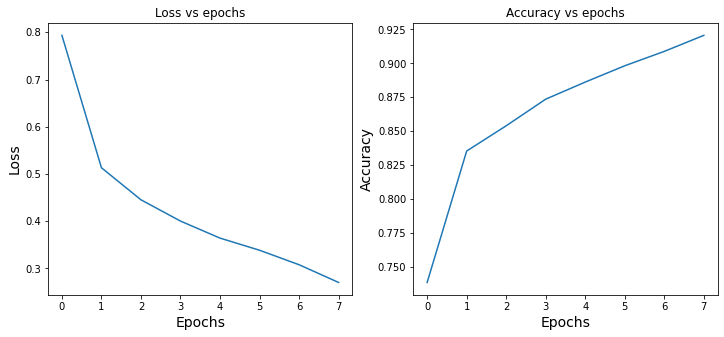

In [15]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 5))

axes[0].set_xlabel("Epochs", fontsize=14)
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].set_title('Loss vs epochs')
axes[0].plot(train_loss_results)

axes[1].set_title('Accuracy vs epochs')
axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epochs", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

#### Evaluate the model performance on the test dataset

In [16]:
# Compute the test loss and accuracy

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

for x, y in test_dataset:
    model_output = resnet_model(x)
    epoch_loss_avg(loss_obj(y, model_output))  
    epoch_accuracy(to_categorical(y), model_output)

print("Test loss: {:.3f}".format(epoch_loss_avg.result().numpy()))
print("Test accuracy: {:.3%}".format(epoch_accuracy.result().numpy()))

Test loss: 0.551
Test accuracy: 83.050%


#### Model predictions

Let's see some model predictions! We will randomly select four images from the test data, and display the image and label for each. 

For each test image, model's prediction (the label with maximum probability) is shown, together with a plot showing the model's categorical distribution.

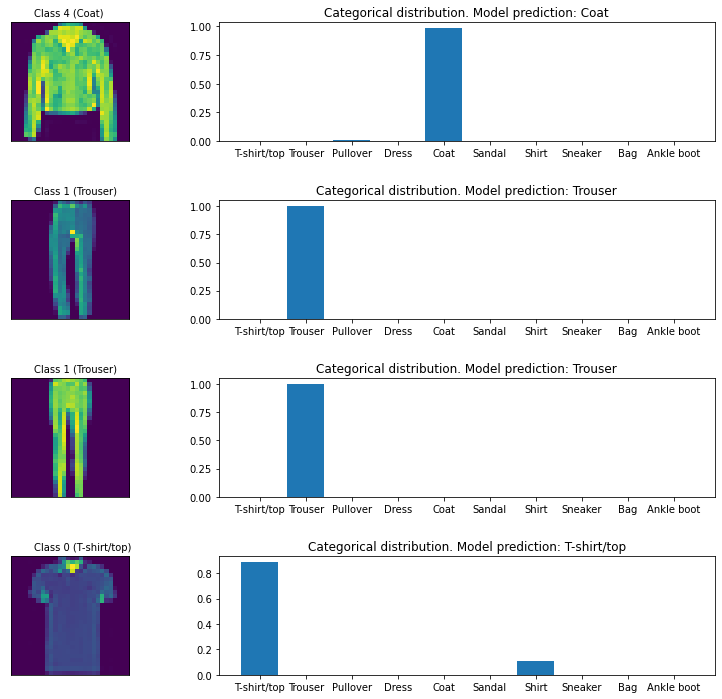

In [17]:
# Run this cell to get model predictions on randomly selected test images

num_test_images = test_images.shape[0]

random_inx = np.random.choice(test_images.shape[0], 4)
random_test_images = test_images[random_inx, ...]
random_test_labels = test_labels[random_inx, ...]

predictions = resnet_model(random_test_images)

fig, axes = plt.subplots(4, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.5, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(5., -2., f'Class {label} ({image_labels[label]})')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_xticklabels(image_labels, rotation=0)
    pred_inx = np.argmax(prediction)
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {image_labels[pred_inx]}")
    
plt.show()

Congratulations for completing this programming assignment! You're now ready to move on to the capstone project for this course.